In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
import os
from pathlib import Path

In [4]:
BASE_PATH = Path(os.path.abspath('')).parent.parent.parent
sys.path.append(str(BASE_PATH))

In [5]:
from bandits.algorithms import *
from bandits.reward_functions import *
from replay_engines.backtester import run_backtest
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime

import matplotlib.pyplot as plt
import scienceplots

%matplotlib inline

# plt.style.use(['science','ieee'])
# plt.style.use(['science','nature'])

## 1. Generating Random Paths with Brownian Class

In [31]:
import numpy as np
import pandas as pd

class SyntheticStockGenerator:
    def __init__(self, n_stocks, time_span, initial_price=100, mu=0.07, sigma=0.2, seed=None):
        """
        Initialize the SyntheticStockGenerator.

        Parameters:
            n_stocks (int): Number of synthetic stock paths to generate.
            time_span (int): Number of days for the stock price history.
            initial_price (float): Initial stock price (default: 100).
            mu (float): Expected annual return (default: 0.07 or 7%).
            sigma (float): Annual volatility (default: 0.2 or 20%).
            seed (int, optional): Random seed for reproducibility.
        """
        self.n_stocks = n_stocks
        self.time_span = time_span
        self.initial_price = initial_price
        self.mu = mu
        self.sigma = sigma
        self.seed = seed
        if seed is not None:
            np.random.seed(seed)

    def generate_paths(self):
        """
        Generate synthetic stock price paths using Geometric Brownian Motion.

        Returns:
            pd.DataFrame: A DataFrame where each column represents a synthetic stock price path.
        """
        dt = 1 / 252  # Daily time step (assuming 252 trading days in a year)
        steps = self.time_span

        # Generate random noise (daily returns)
        random_shocks = np.random.normal(
            loc=(self.mu - 0.5 * self.sigma ** 2) * dt,  # Drift term
            scale=self.sigma * np.sqrt(dt),  # Volatility term
            size=(steps, self.n_stocks)
        )

        # Simulate price paths
        prices = np.exp(np.cumsum(random_shocks, axis=0))
        prices = self.initial_price * prices
        
        # Add initial prices to align the start
        prices = np.vstack([np.full(self.n_stocks, self.initial_price), prices])

        # Create a DataFrame with synthetic stock prices
        dates = pd.date_range(start='2020-01-01', periods=steps + 1)
        df = pd.DataFrame(prices, columns=[f"Stock_{i + 1}" for i in range(self.n_stocks)], index=dates)

        return df

In [91]:
synthetic_stock = SyntheticStockGenerator(
    n_stocks=10, 
    time_span=1000,
    mu=0.07,
    sigma=0.20,
)

df = synthetic_stock.generate_paths()

In [92]:
portfolio = pd.DataFrame(df)
df.to_csv('portfolio_synthetic_data.csv', index=False)    

In [93]:
portfolio = pd.read_csv('portfolio_synthetic_data.csv')

In [94]:
for col in portfolio.columns:
    portfolio[col] = np.log(portfolio[col] / portfolio[col].shift(1))
    portfolio[col] = portfolio[col].fillna(0.)

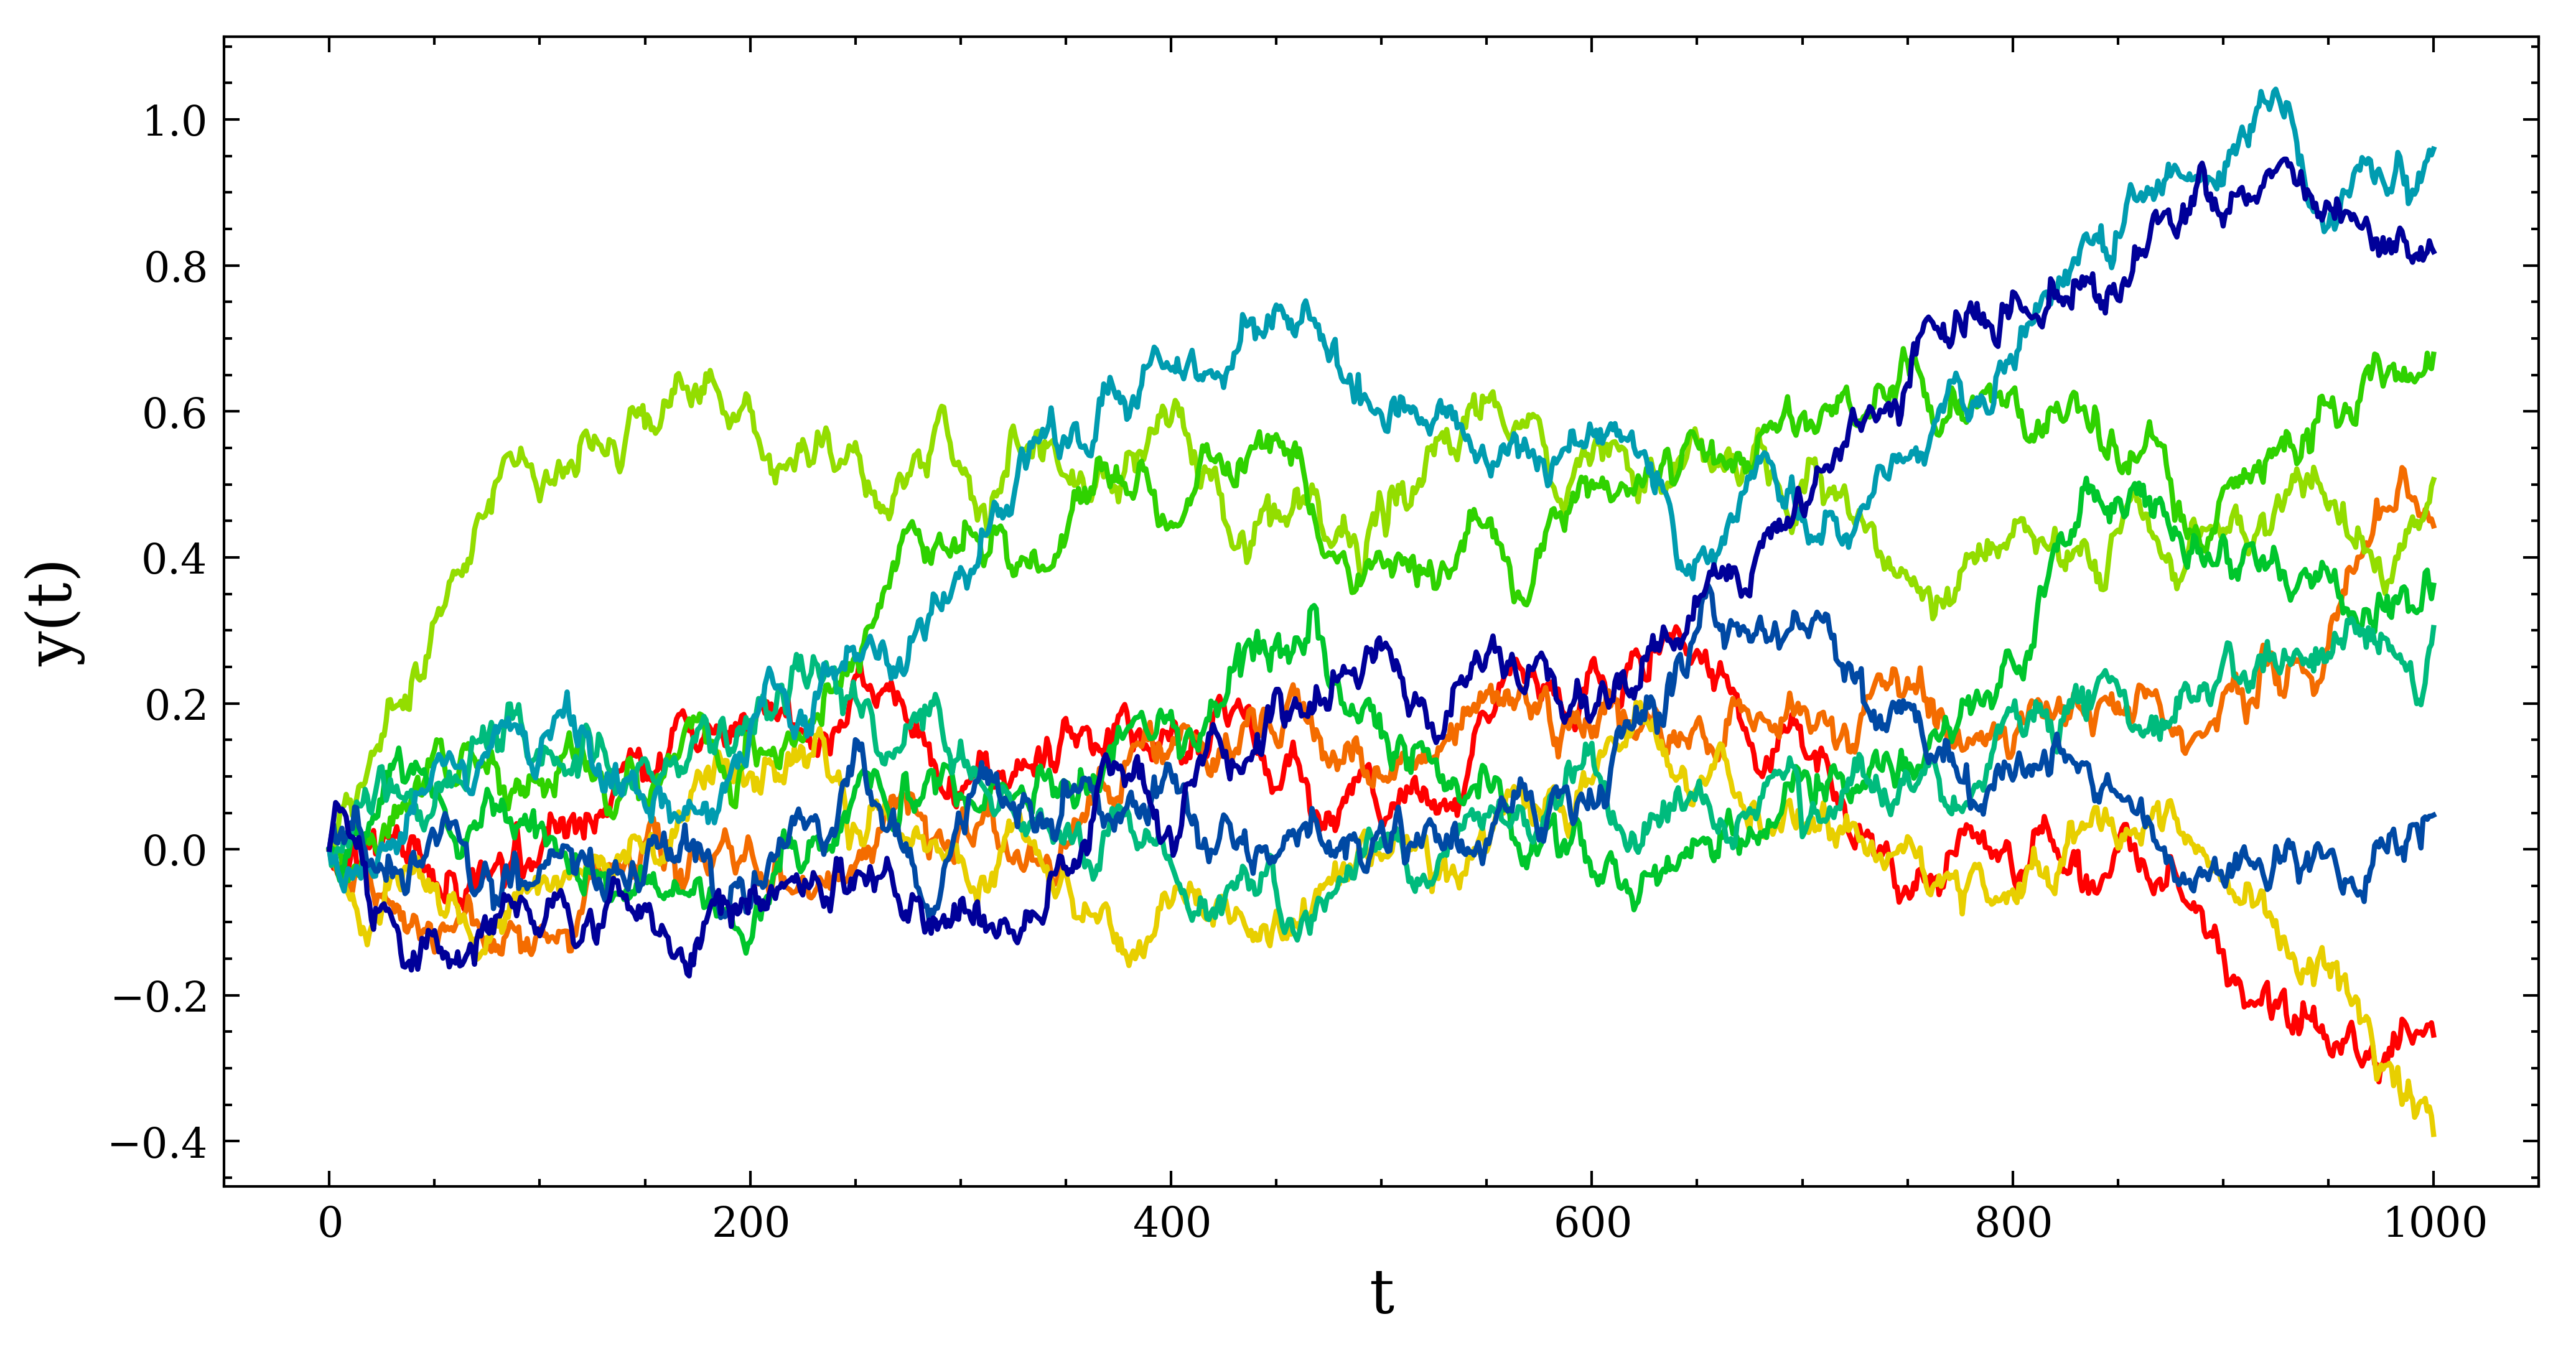

In [95]:
from colour import Color

blue = Color("red", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(portfolio.columns)))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8, 4))
    i = 0
    for col in portfolio.columns:
        plt.plot(portfolio[col].cumsum(), color=colors[i].rgb, linestyle="-")
        i += 1
#     plt.legend(portfolio.columns, fontsize=4)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    plt.savefig('classes.jpg', dpi=600)

In [125]:
n_sim = 50
shift = 0
polices = {
    "ADTS (min)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "min", "w": 30},
        "agents": [],
    },
    "F-DSW TS (min)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "min", "n": 30},
        "agents": [],
    },
    # "ADTS (max)": {
    #     "policy_name": "AdaptiveDiscountedThompsonSampling",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "w": 30},
    #     "agents": [],
    # },
    # "F-DSW TS (max)": {
    #     "policy_name": "CavenaghiFDSWTS",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "n": 30},
    #     "agents": [],
    # },
    # "ADTS (mean)": {
    #     "policy_name": "AdaptiveDiscountedThompsonSampling",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "w": 30},
    #     "agents": [],
    # },
    # "F-DSW TS (mean)": {
    #     "policy_name": "CavenaghiFDSWTS",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "n": 30},
    #     "agents": [],
    # },
    "D TS": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99},
        "agents": [],
    },
    "D UCB": {
        "policy_name": "DiscountedUCB1",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.1},
        "agents": [],
    },
    "SW UCB": {
        "policy_name": "SlidingWindowUCB1",
        "args": {"n_arms": portfolio.shape[1], "w": 50},
        "agents": [],
    },
}
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=ReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["rewards_mxt"] = rewards_mxt
    polices[policy_name]["regret_mxt"] = regret_mxt
    polices[policy_name]["std_reward"] = np.std(rewards_mxt, axis=1)
    polices[policy_name]["mean_reward"] = np.mean(rewards_mxt, axis=1)
    polices[policy_name]["std_regret"] = np.std(regret_mxt, axis=1)
    polices[policy_name]["mean_regret"] = np.mean(regret_mxt, axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


In [126]:
from colour import Color

blue = Color("red", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(polices)))

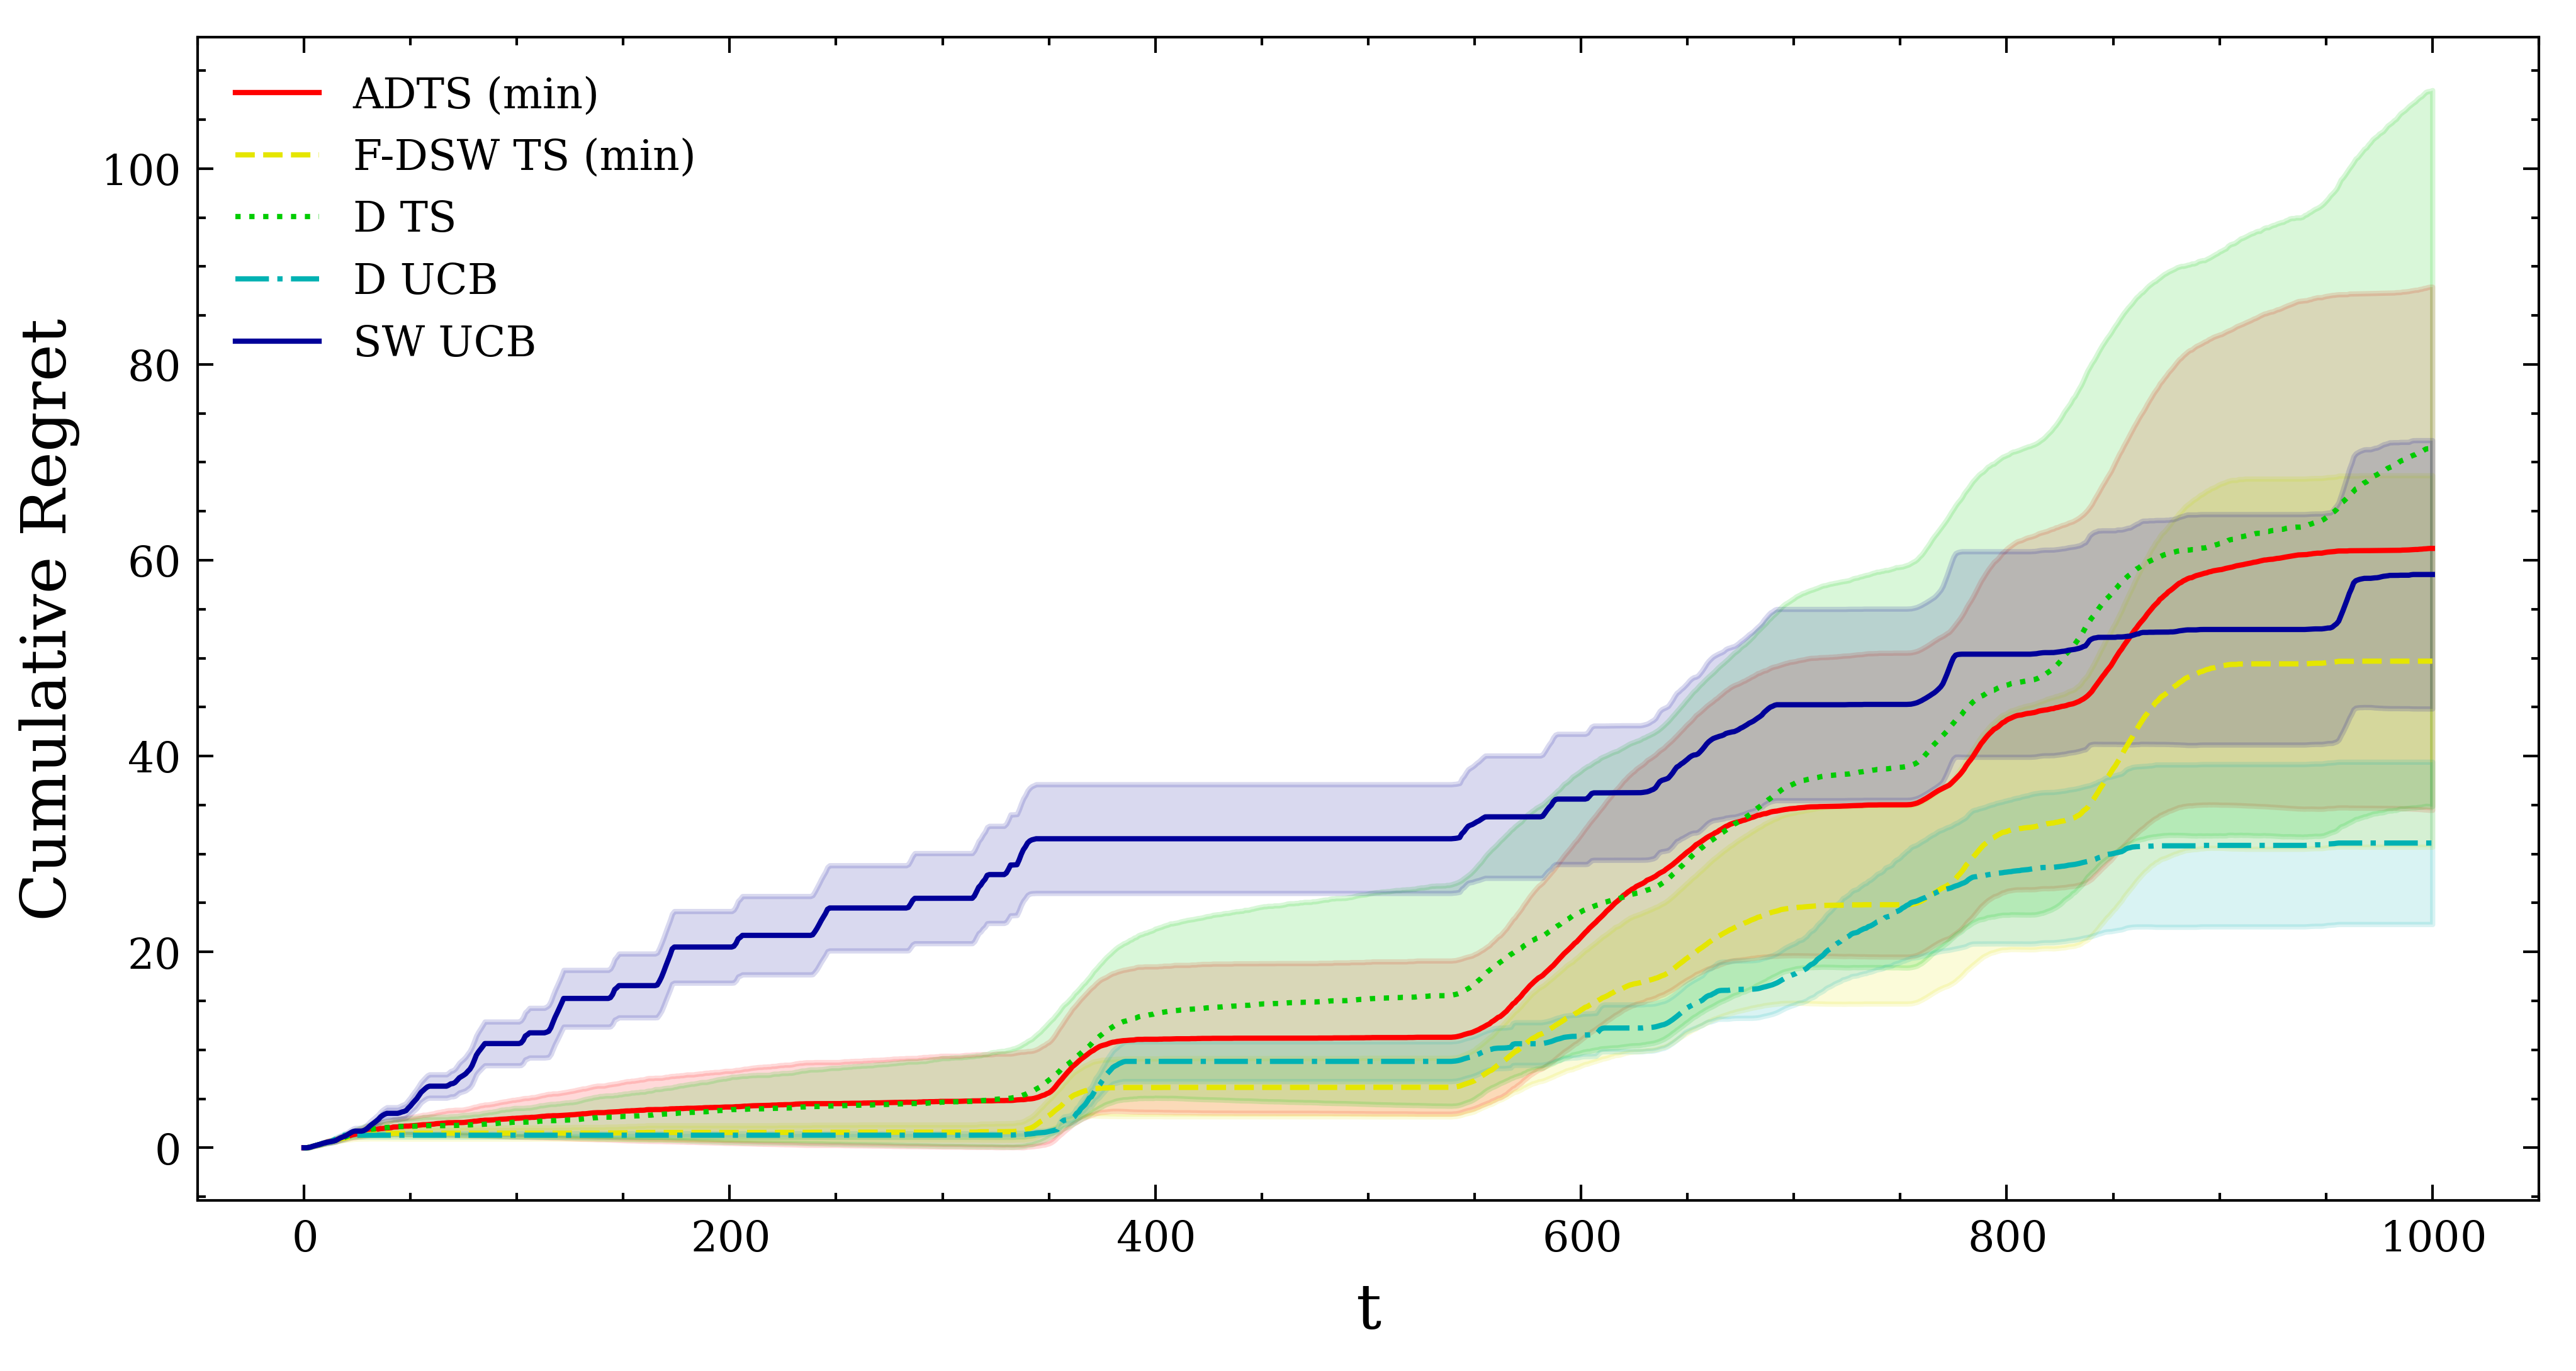

In [143]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8, 4))
    i = 0
    for policy, output in polices.items():
        plt.plot(np.cumsum(output["mean_regret"]), color=colors[i].rgb)
        confidence_interval = 1.96 * output["std_regret"] / np.sqrt(n_sim)
        upper = np.cumsum(output["mean_regret"] + confidence_interval)
        lower = np.cumsum(output["mean_regret"] - confidence_interval)
        plt.fill_between(list(range(len(output["mean_regret"]))), upper, lower, color=colors[i].rgb, alpha=0.15, label='_nolegend_')
        i += 1
    plt.legend([p for p in polices.keys()])
    plt.xlabel('t', fontsize=12)
    plt.ylabel('Cumulative Regret', fontsize=12)
    # plt.yscale('log')
#     plt.grid(True)
    plt.savefig('02_cumulative_regrets.jpg', dpi=600)

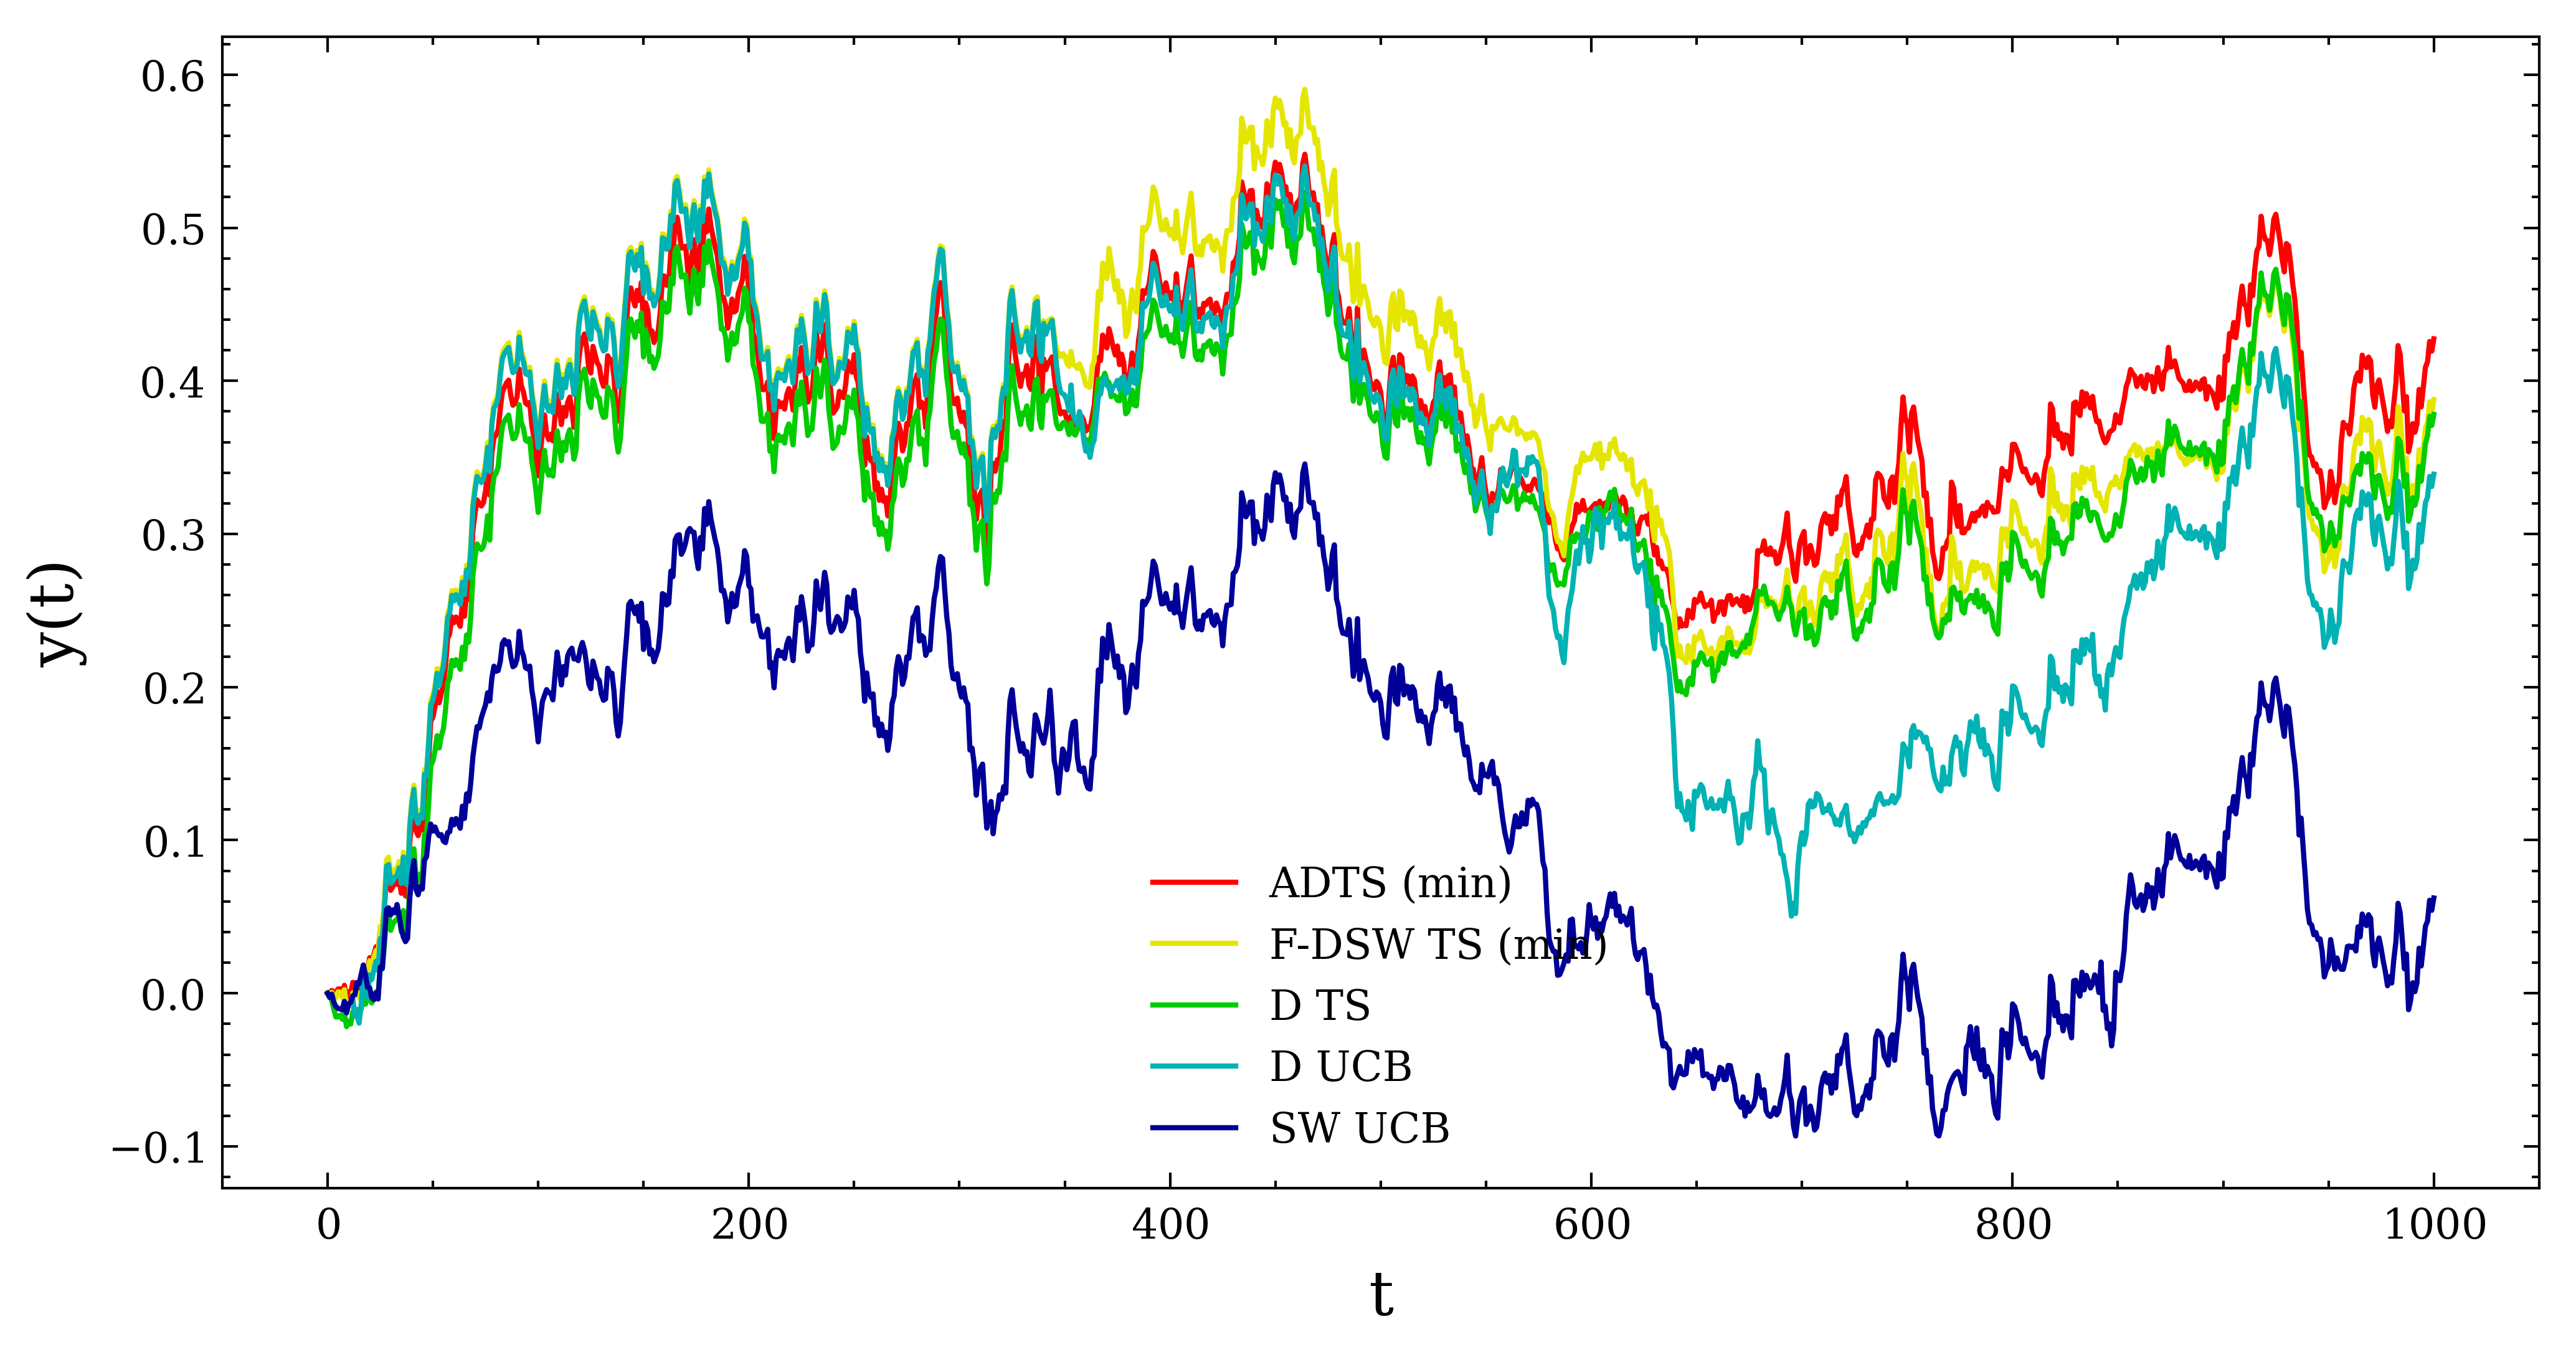

In [145]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8, 4))
    oracle = np.cumsum(portfolio.mean(axis=1))
    # plt.plot(oracle, linewidth=1.5)
    legend = []#["Oracle"]
    i = 0
    for policy, output in polices.items():
        plt.plot(np.cumsum(output["mean_reward"]), color=colors[i].rgb, linestyle="-")
        legend.append(policy)
        i+=1
    
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    plt.legend(legend)
    plt.savefig('03_rewards_versus_oracle.jpg', dpi=600)

In [146]:
import numpy as np

# Generate LaTeX table
table = "\\begin{table}[h]\n"
table += "\\centering\n"
table += "\\begin{tabular}{lcc}\n"
table += "\\hline\n"
table += "Algorithm & Mean Cumulative Regret $\\pm$ Std Dev \\\\\n"
table += "\\hline\n"
for policy, output in polices.items():
    mean_regret = np.cumsum(output["mean_regret"])
    confidence_interval = 1.96 * output["std_regret"] / np.sqrt(n_sim)
    upper = np.cumsum(output["mean_regret"] + confidence_interval)
    lower = np.cumsum(output["mean_regret"] - confidence_interval)
    table += f"{policy} & ${mean_regret[-1]:.1f} \\pm {(upper[-1] - mean_regret[-1]):.1f}$ \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\caption{Comparison of Mean Cumulative Regrets with Std Dev for Various MAB Algorithms (based on 100 simulations)}\n"
table += "\\end{table}\n"

print(table)

\begin{table}[h]
\centering
\begin{tabular}{lcc}
\hline
Algorithm & Mean Cumulative Regret $\pm$ Std Dev \\
\hline
ADTS (min) & $61.2 \pm 26.7$ \\
F-DSW TS (min) & $49.7 \pm 19.0$ \\
D TS & $71.4 \pm 36.6$ \\
D UCB & $31.1 \pm 8.3$ \\
SW UCB & $58.5 \pm 13.7$ \\
\hline
\end{tabular}
\caption{Comparison of Mean Cumulative Regrets with Std Dev for Various MAB Algorithms (based on 100 simulations)}
\end{table}



In [148]:
import numpy as np

def calculate_metrics(log_returns):
    returns = np.exp(log_returns) - 1
    cumulative_returns = np.cumprod(1 + returns) - 1
    daily_returns = np.mean(returns)
    volatility = np.std(returns)
    drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))
    win_rate = np.sum(returns > 0) / len(returns)
    
    # Risk-adjusted ratios
    risk_free_rate = 0.0  # Assuming risk-free rate is zero
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    downside_deviation = np.std(excess_returns[excess_returns < 0])
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    calmar_ratio = np.mean(excess_returns) / drawdown
    
    return {
        "Cumulative Returns": cumulative_returns[-1],
#         "Average Daily Returns": daily_returns,
#         "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Drawdown": drawdown,
        "Win Rate": win_rate,
        "Sortino Ratio": sortino_ratio,
#         "Calmar Ratio": calmar_ratio
    }

In [149]:
portfolio_history = {}
index = []

polices_copy = polices.copy()
for policy, output in polices_copy.items():
    metrics_dict = calculate_metrics(output["mean_reward"])
    for k, v in metrics_dict.items():
        if k not in portfolio_history.keys():
            portfolio_history[k] = [v]
        else:
            portfolio_history[k].append(v)
    index.append(policy)
df = pd.DataFrame(portfolio_history, index=index)
df = df.sort_values("Cumulative Returns", ascending=False)
df

,Cumulative Returns,Sharpe Ratio,Drawdown,Win Rate,Sortino Ratio
ADTS (min),0.533317,0.708125,-0.460169,0.502498,0.076998
F-DSW TS (min),0.473666,0.633786,-0.565482,0.487512,0.070496
D TS,0.459474,0.652718,-0.472470,0.497502,0.071478
D UCB,0.403616,0.553579,-0.665016,0.485514,0.061781
SW UCB,0.064211,0.176909,-0.502058,0.481518,0.019278


## 2- Investigating the effect of discount (gamma) in d TS

In [163]:
gamma_vec = np.linspace(0., 1., 11)

In [164]:
gamma_vec

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [165]:
n_sim = 50
polices = {
    f"D TS {i}": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i]},
        "agents": [],
    }
    for i in range(len(gamma_vec))
}
polices.update(
    {   
        f"ADTS (min) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "w": 30},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "n": 30},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
polices.update(
    {   
        f"Classical TS {i}": {
            "policy_name": "ThompsonSampling",
            "args": {"n_arms": portfolio.shape[1]},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)

In [166]:
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=ReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["regret"] = np.mean(regret_mxt, axis=1).mean()
    polices[policy_name]["reward"] = np.mean(rewards_mxt, axis=1).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.09it/s]
/Users/gfonseca/Desktop/Doutorado - EEC-I/Pesquisa/bandits-lib/venv/lib/python3.9/site-packages/multi_armed_bandit/algorithms/bernoulli_dist/min_dsw_ts.py:33: RuntimeWarning: invalid value encountered in scalar divide00:00<?, ?it/s]
  self._mean_trace[a].append(self._betas[a][1] / (self._betas[a][1] + self._betas[a][0]))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.14it/s]


In [167]:
groups = ["D TS", "ADTS (min)", "FDSWTS (min)", "Classical TS"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "gamma_vec": gamma_vec,
        "reward": []
    }
    for k, v in polices.items():
        if g in k:
            results_dict[g]["reward"].append(v["reward"])

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_41139/3638698197.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["reward"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_41139/3638698197.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["reward"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_41139/3638698197.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The k

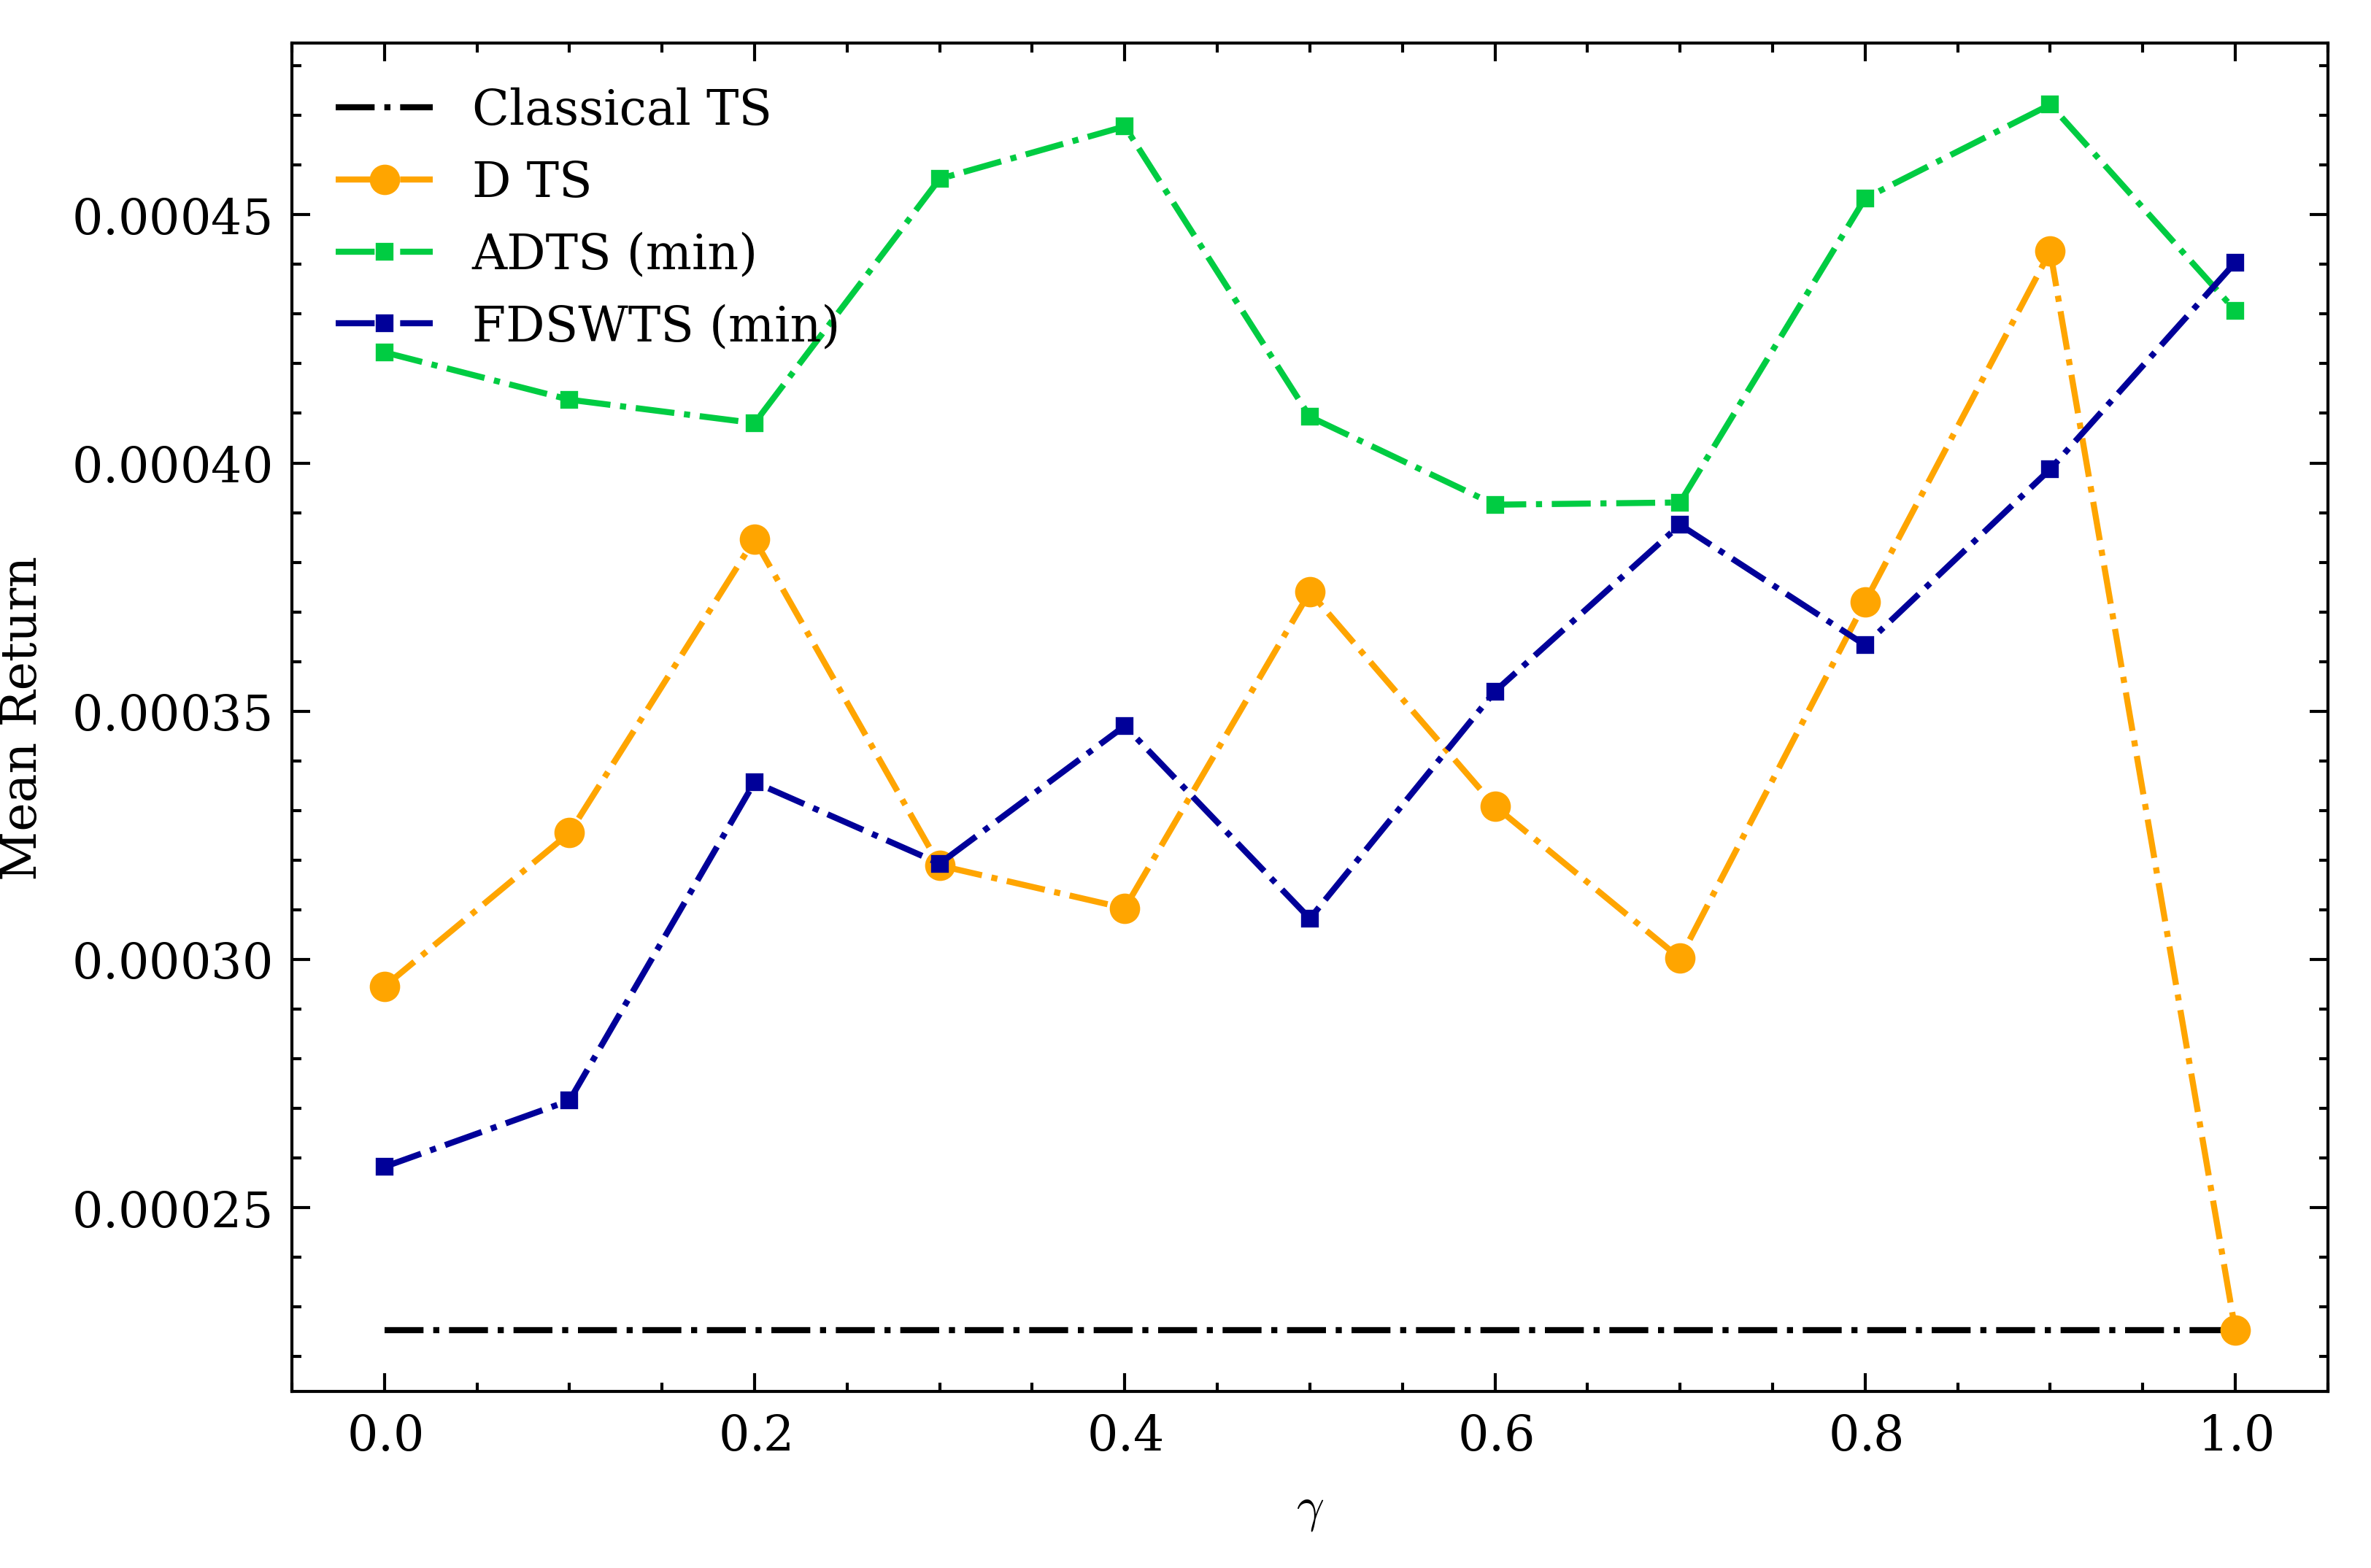

In [168]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

x_min = 0.79
x_max = 1.01
y_min = 0.
y_max = 1.5

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 4))
    legend = []
    i = 0
    plt.plot(results_dict["Classical TS"]["gamma_vec"], results_dict["Classical TS"]["reward"], color="k", linestyle="-.")
    plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["reward"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["reward"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
    plt.plot(results_dict["FDSWTS (min)"]["gamma_vec"], results_dict["FDSWTS (min)"]["reward"], "-s", markersize=2, color=colors[2].rgb, linestyle="-.")
    
    # plt.plot([x_min, x_min], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_max, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_max, x_max], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_min, y_min], color='r', linewidth=1, linestyle="--")
    
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Mean Return')
    plt.legend(["Classical TS", "D TS", "ADTS (min)", "FDSWTS (min)"])
    plt.savefig('04_effect_of_gamma.jpg', dpi=600)

## 3- Investigating the window size (w) on sw-d TS

In [169]:
w_vec = np.linspace(0, 100, 11)

In [170]:
w_vec[0] = 1

In [171]:
w_vec

array([  1.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [181]:
n_sim = 30
polices = {
    f"D TS {i}": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.9},
        "agents": [],
    }
    for i in range(len(w_vec))
}
polices.update(
    {   
        f"ADTS (min) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "min", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"ADTS (mean) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "mean", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"ADTS (max) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "max", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "min", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (mean) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "mean", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (max) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "max", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)

In [182]:
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=ReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["regret"] = np.mean(regret_mxt, axis=1).mean()
    polices[policy_name]["reward"] = np.mean(rewards_mxt, axis=1).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.18it/s]


In [183]:
# groups = ["d TS", "min d-sw TS", "avg d-sw TS", "max d-sw TS", "Classical TS"]
groups = ["D TS", "ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "w_vec": w_vec,
        "reward": []
    }
    for k, v in polices.items():
        if g in k:
            results_dict[g]["reward"].append(v["reward"])

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_41139/3533527270.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["reward"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_41139/3533527270.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["FDSWTS (min)"]["w_vec"], results_dict["FDSWTS (min)"]["reward"], "-s", markersize=2, color=colors[3].rgb, linestyle="-")


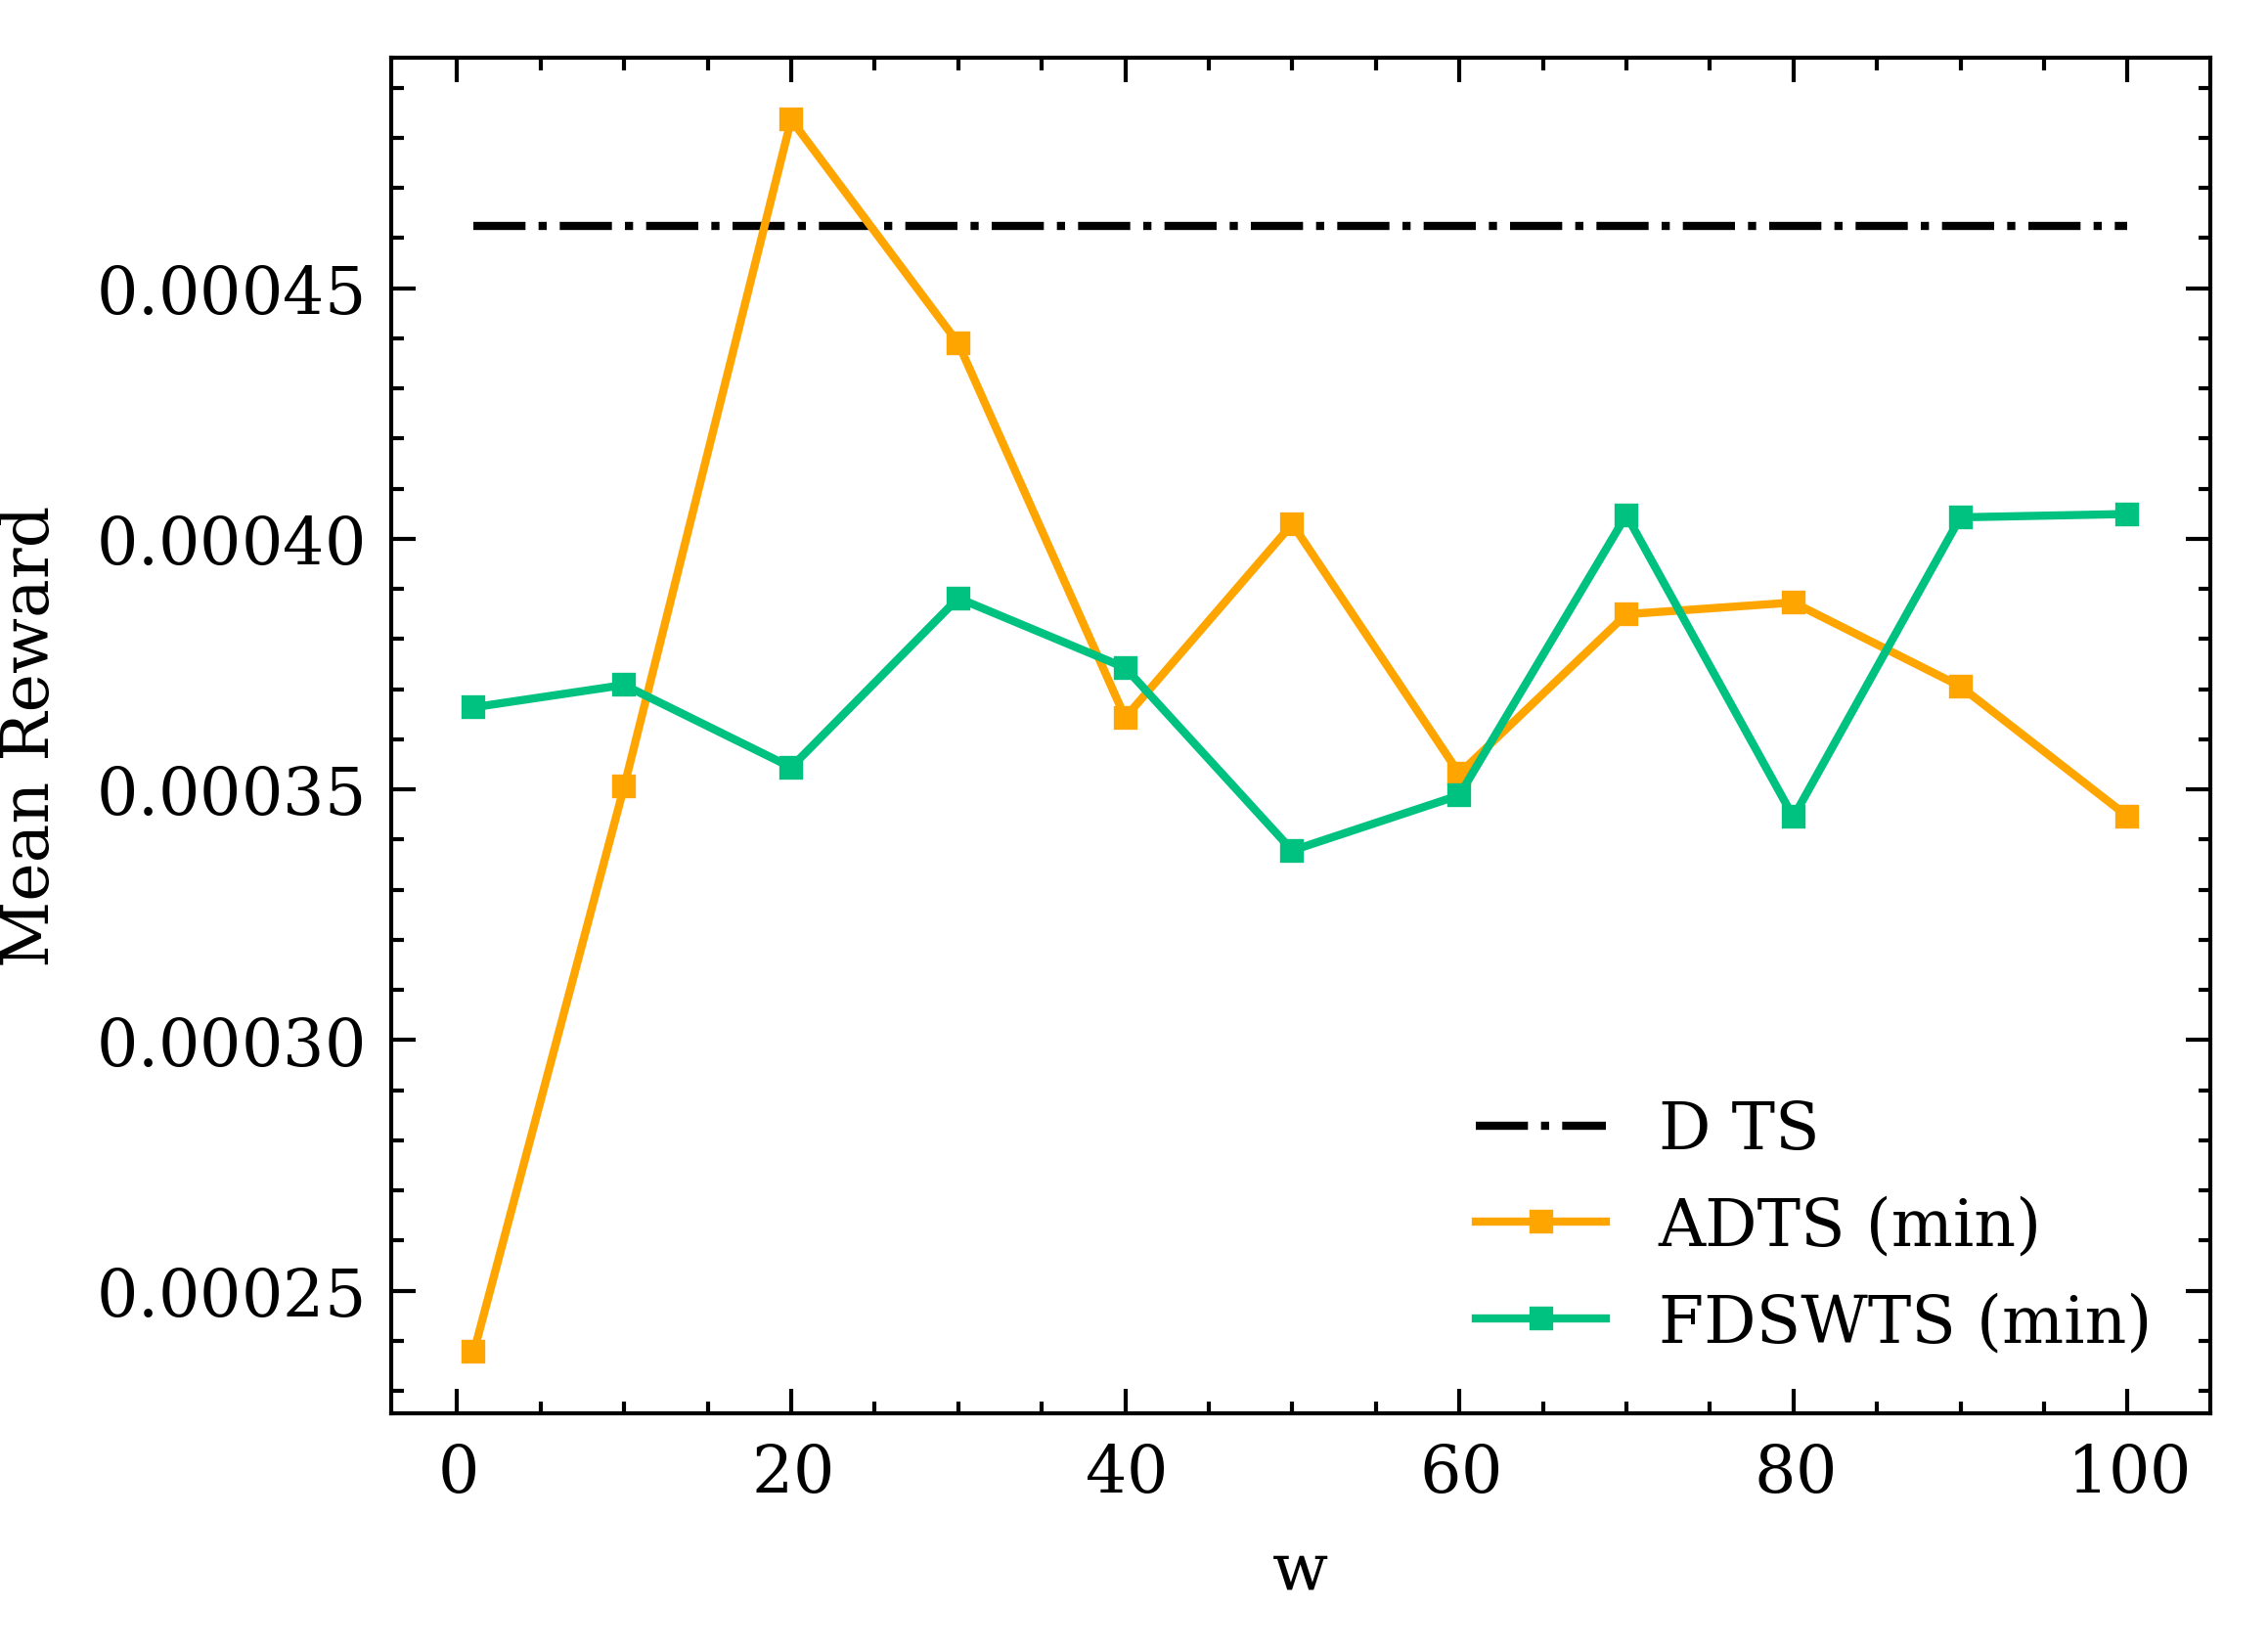

In [187]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

x_min = -10
x_max = 110
y_min = 0.
y_max = 0.4

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["D TS"]["w_vec"], results_dict["D TS"]["reward"], color="k", linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["reward"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
    # plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["reward"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
    # plt.plot(results_dict["ADTS (max)"]["w_vec"], results_dict["ADTS (max)"]["reward"], "-^", markersize=2, color=colors[2].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (min)"]["w_vec"], results_dict["FDSWTS (min)"]["reward"], "-s", markersize=2, color=colors[3].rgb, linestyle="-")
    # plt.plot(results_dict["FDSWTS (mean)"]["w_vec"], results_dict["FDSWTS (mean)"]["reward"], "-o", markersize=2, color=colors[4].rgb, linestyle="-")
    # plt.plot(results_dict["FDSWTS (max)"]["w_vec"], results_dict["FDSWTS (max)"]["reward"], "-^", markersize=2, color=colors[5].rgb, linestyle="-")
    
    # plt.plot([x_min, x_min], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_max, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_max, x_max], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_min, y_min], color='r', linewidth=1, linestyle="--")
#     plt.plot(results_dict["d $\sigma$-TS"]["gamma_vec"], results_dict["d $\sigma$-TS"]["regret"], "-^", markersize=2, color=colors[2].rgb, linestyle="-.")
#     for k, v in results_dict.items():
#         plt.plot(v["gamma_vec"], v["regret"], color=colors[i].rgb, linestyle="-.")
#         plt.scatter(v["gamma_vec"], v["regret"], s=2, c=colors[i].rgb)#, linestyle="-.")
#         legend.append(k)
#         i+=1
    plt.xlabel('w')
    plt.ylabel('Mean Reward')
    plt.legend(["D TS", "ADTS (min)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"])
    plt.savefig('05_effect_of_w.jpg', dpi=600)